In [ ]:
import pandas as pd

apfs_df = pd.read_csv(r'Initial_data/ac_power_from_storage.csv')
apts_df = pd.read_csv(r'Initial_data/ac_power_to_storage.csv')
gc_df = pd.read_csv(r'Initial_data/grid_consumption.csv')
gf_df = pd.read_csv(r'Initial_data/grid_feed.csv')
pp_df = pd.read_csv(r'Initial_data/pv_production.csv')


In [ ]:
'''Convert the time column to a time type'''

apfs_df['time'] = pd.to_datetime(apfs_df['time'])
apts_df['time'] = pd.to_datetime(apts_df['time'])
gc_df['time'] = pd.to_datetime(gc_df['time'])
gf_df['time'] = pd.to_datetime(gf_df['time'])
pp_df['time'] = pd.to_datetime(pp_df['time'])
gc_df.to_csv(r'result/gen.csv', index=False)

'''Set the time as an index'''

apfs_df.set_index('time', inplace=True)
apts_df.set_index('time', inplace=True)
gc_df.set_index('time', inplace=True)
gf_df.set_index('time', inplace=True)
pp_df.set_index('time', inplace=True)
gc_df.to_csv(r'result/gen1.csv', index=False)


'''Convert the column of values to float type'''

apfs_df['ac_power_from_storage'] = apfs_df['ac_power_from_storage'].astype(float)
apts_df['ac_power_to_storage'] = apts_df['ac_power_to_storage'].astype(float)
gc_df['grid_consumption'] = gc_df['grid_consumption'].astype(float)
gf_df['grid_feed'] = gf_df['grid_feed'].astype(float)
pp_df['pv_production'] = pp_df['pv_production'].astype(float)
gc_df.to_csv(r'result/gen2.csv', index=False)


In [ ]:
# Мердж данных. Здесь я использовал мердж для того, чтобы в нашем датасете произвести расчет нагрузки энергопотребления до момента ресэмплирования. По итогу в файле P_l получаем реальные данные(без подстановки нулей) с разрывами в значениях.

import pandas as pd
import numpy as np
from datetime import datetime


# Чтение всех датасетов
apfs_df = pd.read_csv(r'Initial_data/ac_power_from_storage.csv')
apts_df = pd.read_csv(r'Initial_data/ac_power_to_storage.csv')
gc_df = pd.read_csv(r'Initial_data/grid_consumption.csv')
gf_df = pd.read_csv(r'Initial_data/grid_feed.csv')
pp_df = pd.read_csv(r'Initial_data/pv_production.csv')

# Объединение датасетов
merged_df = apfs_df.merge(apts_df, on='time', how='outer') \
                  .merge(gc_df, on='time', how='outer') \
                  .merge(gf_df, on='time', how='outer') \
                  .merge(pp_df, on='time', how='outer')

# Преобразование столбца 'datetime' в datetime
merged_df['time'] = pd.to_datetime(merged_df['time'])

# Установка 'datetime' как индекс
merged_df.set_index('time', inplace=True)

# Рассчитываем P_l
merged_df['P_l'] = merged_df['pv_production'] + merged_df['grid_consumption'] + \
                   merged_df['ac_power_from_storage'] - merged_df['grid_feed'] - \
                   merged_df['ac_power_to_storage']

# Сохраняем результат в CSV
merged_df.to_csv(r'result/merged_df_with_P_l.csv')

# Выбираем только столбцы 'time' и 'P_l' из merged_df
result_df = merged_df[['P_l']]

# Сохраняем результат в CSV
result_df.to_csv(r'result/P_l.csv')





In [ ]:
# Код аналогичен верхнему, только сделал ресэмплирование по 5 мин

from datetime import datetime
import pandas as pd
import numpy as np

# Чтение всех датасетов
apfs_df = pd.read_csv(r'Initial_data/ac_power_from_storage.csv')
apts_df = pd.read_csv(r'Initial_data/ac_power_to_storage.csv')
gc_df = pd.read_csv(r'Initial_data/grid_consumption.csv')
gf_df = pd.read_csv(r'Initial_data/grid_feed.csv')
pp_df = pd.read_csv(r'Initial_data/pv_production.csv')

# Объединение датасетов
merged_df = apfs_df.merge(apts_df, on='time', how='outer') \
                  .merge(gc_df, on='time', how='outer') \
                  .merge(gf_df, on='time', how='outer') \
                  .merge(pp_df, on='time', how='outer')

# Преобразование столбца 'datetime' в datetime
merged_df['time'] = pd.to_datetime(merged_df['time'])

# Установка 'datetime' как индекс
merged_df.set_index('time', inplace=True)

# Рассчитываем P_l
merged_df['P_l'] = merged_df['pv_production'] + merged_df['grid_consumption'] + \
                   merged_df['ac_power_from_storage'] - merged_df['grid_feed'] - \
                   merged_df['ac_power_to_storage']

# Сохраняем результат в CSV
merged_df.to_csv(r'result/merged_df_with_P_l.csv')

# Выбираем только столбцы 'time' и 'P_l' из merged_df
result_df = merged_df[['P_l']]

# Сохраняем результат в CSV
result_df.to_csv(r'result/P_l.csv')

# Create an empty DataFrame with the time index
index = pd.date_range(start_date, end_date, freq='5T')
df_general = pd.DataFrame(index=index)

# Сохраняем пустой DataFrame в CSV
df_general.to_csv(r'result/df_general.csv')


In [8]:
# Здесь мы убираем нули из нашего датасета
import pandas as pd

# Загрузите данные P_l из файла P_l.csv
df_P_l = pd.read_csv(r'result/P_l.csv')

# Преобразуйте столбец 'time' в datetime и установите его в качестве индекса
df_P_l['time'] = pd.to_datetime(df_P_l['time'])
df_P_l.set_index('time', inplace=True)

# Укажите частоту, с которой вы хотите пересэмплировать данные (например, '5T' для 5 минут)
resample_frequency = '5T'

# Пересэмплируйте данные с использованием суммирования для заполнения пропусков
df_resampled = df_P_l.resample(resample_frequency).sum()

# Замените нули на NaN
df_resampled['P_l'] = df_resampled['P_l'].where(df_resampled['P_l'] != 0, pd.NA)

# Сохраните результат в CSV
df_resampled.to_csv(r'result/filled_P_l.csv')




In [17]:
df_work_data = df_resampled

In [18]:
df_work_data['initial_data_T_F'] = df_resampled['P_l'].notna()

In [28]:
import pandas as pd
import numpy as np
import random



# Пример DataFrame
data = {'time': pd.date_range(start='2016-06-10 16:00:00', periods=10, freq='5T'),
        'P_l': [26441.630, 26039.196, np.nan, 22824.290, 23408.187, 26441.630, np.nan, 21790.632, 26039.196, 22824.290]}

df = pd.DataFrame(data)

def poisson_value(date_with_nan, dataframe, time_window_minutes=5):
    # Найти индекс строки с заданной датой
    mask = dataframe['time'] == date_with_nan
    if mask.any():
        index_with_nan = dataframe.index[mask][0]
    else:
        return []  # Вернуть пустой список, если дата не найдена

    # Найти диапазон времени для поиска существующих значений
    time_range = pd.to_timedelta(time_window_minutes, unit='m')
    start_time = dataframe.loc[index_with_nan, 'time'] - time_range
    end_time = dataframe.loc[index_with_nan, 'time'] + time_range

    # Найти существующие значения в заданном диапазоне времени
    mask = (dataframe['time'] >= start_time) & (dataframe['time'] <= end_time) & (~dataframe['P_l'].isna())
    existing_values = dataframe.loc[mask, 'P_l'].tolist()
    mean_value = np.mean(existing_values)
    count_index = 1000
    s = np.random.poisson(mean_value, count_index).tolist()
    index = random.randint(0, 999)
    poisson_value = s[index]
    return poisson_value

# Пример использования функции
date_with_nan = pd.to_datetime('2016-06-10 16:05:00')
existing_values = find_existing_values(date_with_nan, df)
print(existing_values)

TypeError: 'module' object is not callable

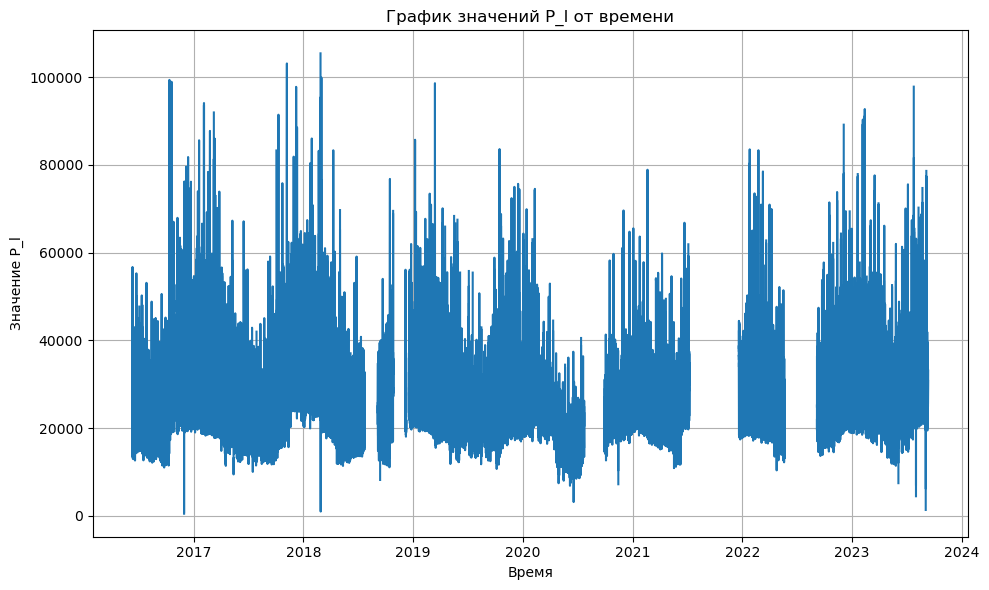

In [16]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))  # Установка размера графика (опционально)

plt.plot(df_resampled.index, df_resampled['P_l'], linestyle='-')

plt.title('График значений P_l от времени')
plt.xlabel('Время')
plt.ylabel('Значение P_l')

plt.grid(True)  # Добавление сетки на график (опционально)

plt.xticks()  # Поворот подписей по оси x (опционально)

plt.tight_layout()  # Улучшение отображения графика

plt.show()
